In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from scipy.optimize import differential_evolution
import seaborn as sns
import optuna

/Users/amirashrafizham/anaconda3/envs/concrete-compressive-strength/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data Loading

In [2]:
df = pd.read_csv("../database/concrete_data.csv")
df.head()

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,concrete_compressive_strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


Features

- Cement (kg)
- Blast Furnace Slag (kg) 
- Fly Ash (kg)
- Water (kg) 
- Superplasticizer (kg) 
- Coarse Aggregate (kg)
- Fine Aggregate (kg) 
- Age (Day)

Label
- Concrete compressive strength (MPa)

### Model Training

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error,r2_score
from sklearn import linear_model 

import warnings 
import numpy as np

# Remove outliers using IQR
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]


X = df.drop('concrete_compressive_strength', axis=1)
y = df['concrete_compressive_strength']

# Split the data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#lr = linear_model.LinearRegression()
#model_lr = lr.fit(X_train, y_train)
#y_pred = model_lr.predict(X_test)
#rmse = np.sqrt(root_mean_squared_error(y_pred=y_pred,y_true=y_test))
#r2 = r2_score(y_pred=y_pred,y_true=y_test)
#print(f"RMSE:{rmse}\nR-Squared:{r2}")

lgbm = lgb.LGBMRegressor(verbose=-1)
model_lgbm = lgbm.fit(X_train, y_train)
y_pred = model_lgbm.predict(X_test)
rmse = np.sqrt(root_mean_squared_error(y_pred=y_pred,y_true=y_test))
r2 = r2_score(y_pred=y_pred,y_true=y_test)
print(f"RMSE:{rmse}\nR-Squared:{r2}")

RMSE:2.2841879369080176
R-Squared:0.8952906006788948


### Hyperparameter Tuning

In [4]:
# Using Optuna to optimize the hyperparameters using a Linear Regression model
# Suppress Optuna warnings
def objective(trial):
    warnings.filterwarnings("ignore")
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return np.sqrt(root_mean_squared_error(y_pred=y_pred,y_true=y_test))

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

best_params = study.best_params
best_params['objective'] = 'regression'
best_params['metric'] = 'rmse'
best_params['verbosity'] = -1
best_params['boosting_type'] = 'gbdt'
best_params['num_leaves'] = int(best_params['num_leaves'])

model_lgbm = lgb.LGBMRegressor(**best_params)
model_lgbm.fit(X_train, y_train)
y_pred = model_lgbm.predict(X_test)
rmse = np.sqrt(root_mean_squared_error(y_pred=y_pred,y_true=y_test))
r2 = r2_score(y_pred=y_pred,y_true=y_test)
print(f"RMSE:{rmse}\nR-Squared:{r2}")

[I 2024-11-01 13:01:59,788] A new study created in memory with name: no-name-2b72082e-1469-4d0e-b534-fcf4e8c48235


[I 2024-11-01 13:01:59,862] Trial 0 finished with value: 2.396618487852757 and parameters: {'lambda_l1': 5.551067439304252e-05, 'lambda_l2': 1.5345888342115175, 'num_leaves': 188, 'feature_fraction': 0.570157097274159, 'bagging_fraction': 0.9172987941011228, 'bagging_freq': 4, 'min_child_samples': 100}. Best is trial 0 with value: 2.396618487852757.
[I 2024-11-01 13:01:59,901] Trial 1 finished with value: 2.539368600556147 and parameters: {'lambda_l1': 0.00011183884477605724, 'lambda_l2': 4.483090002421696e-08, 'num_leaves': 136, 'feature_fraction': 0.7948055360713315, 'bagging_fraction': 0.5283782816283297, 'bagging_freq': 1, 'min_child_samples': 73}. Best is trial 0 with value: 2.396618487852757.
[I 2024-11-01 13:01:59,955] Trial 2 finished with value: 2.3910110960468294 and parameters: {'lambda_l1': 0.1820422176995163, 'lambda_l2': 0.00021758504479771573, 'num_leaves': 89, 'feature_fraction': 0.6326656388893379, 'bagging_fraction': 0.9334758039740703, 'bagging_freq': 7, 'min_child_s

RMSE:2.3314516316173894
R-Squared:0.8863514304933624


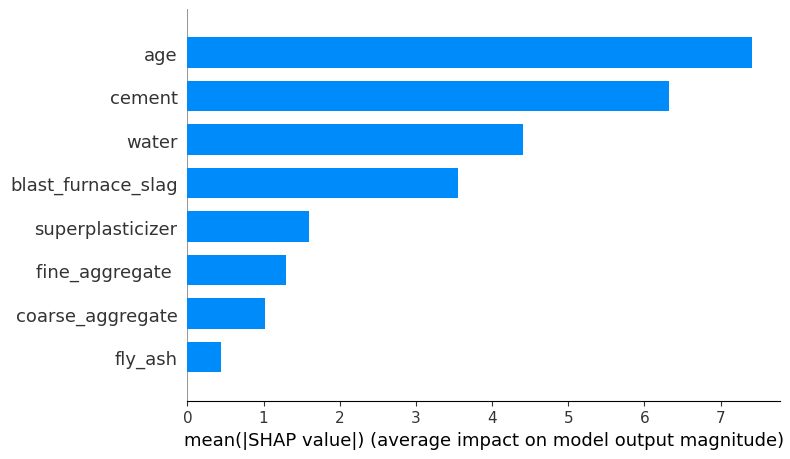

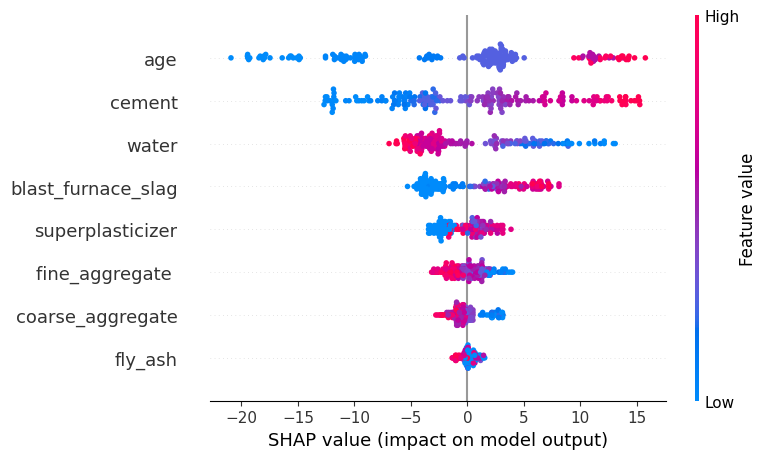

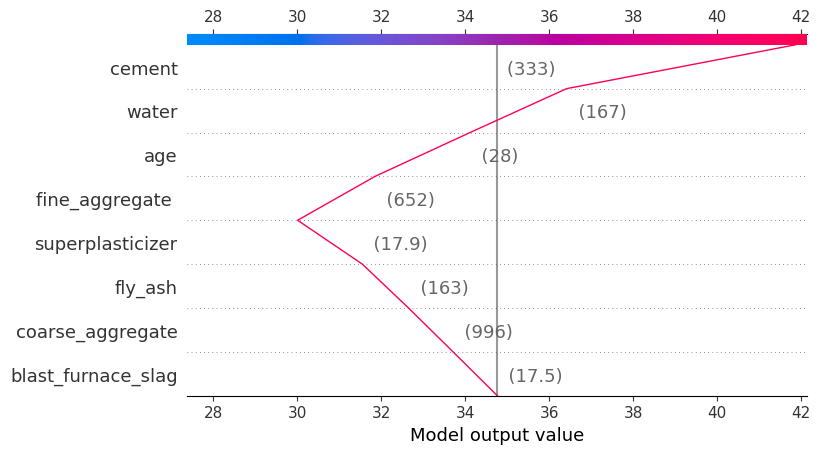

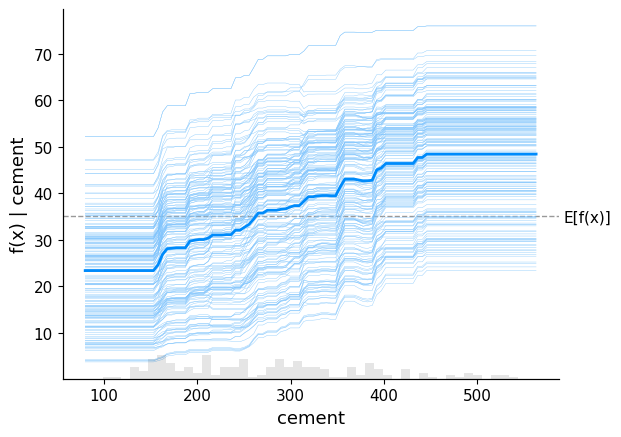

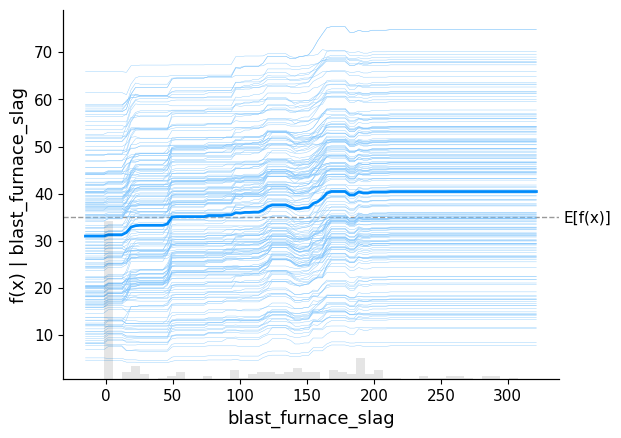

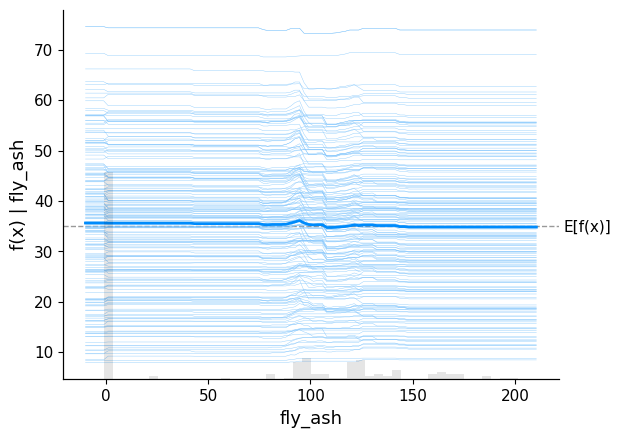

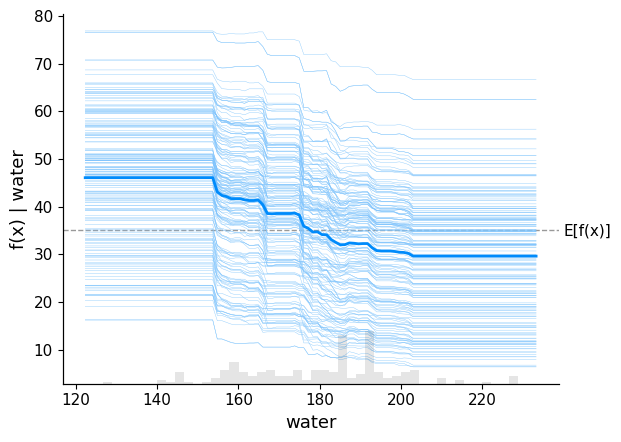

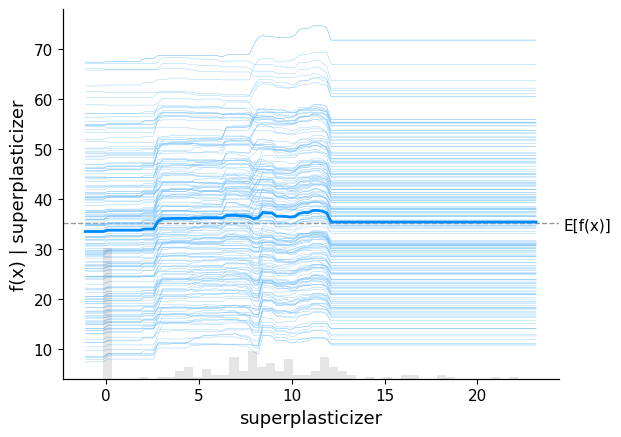

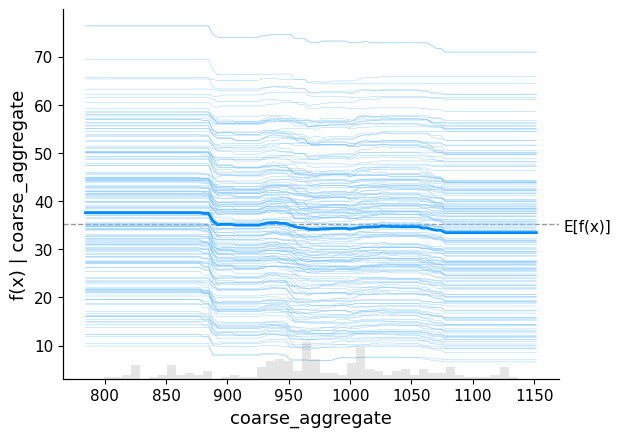

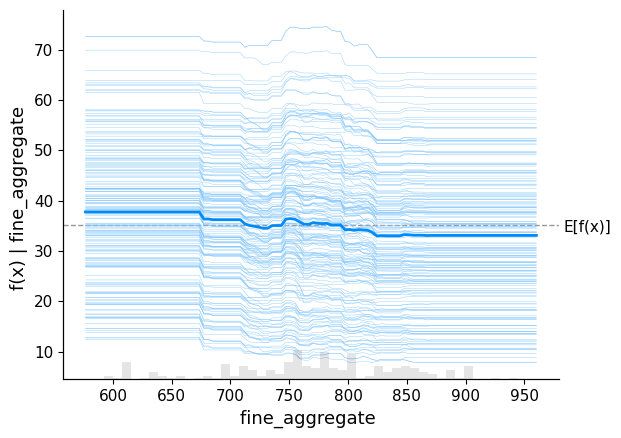

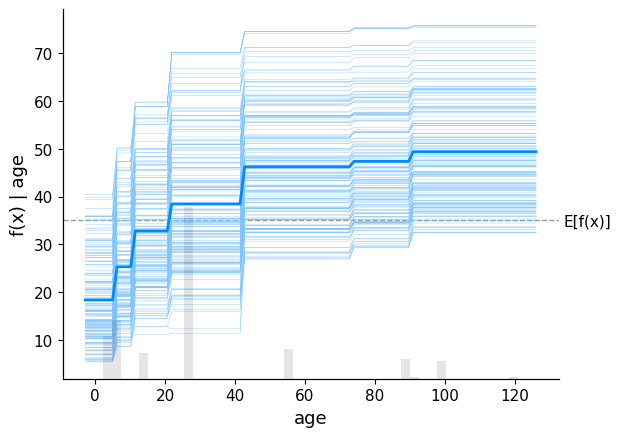

In [5]:
# Using SHAP to explain the model
import shap
shap.initjs()

explainer = shap.TreeExplainer(model_lgbm)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")

# Plot a bee swarm plot
shap.summary_plot(shap_values, X_test)

# Plot a force plot
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

# Plot a decision plot
shap.decision_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

# Plot a partial dependence plot
for i in X.columns:
    # dependence plot
    shap.partial_dependence_plot(i, model_lgbm.predict, X_test, model_expected_value=True)

In [8]:
# Store the machine learning model in pkl
import joblib
joblib.dump(model_lgbm, '../models/cement_model.pkl')

# Store the best hyperparameters in a json file
import json
with open('../models/params.json', 'w') as f:
    json.dump(best_params, f)

# Store the feature names in a json file
with open('../models/features.json', 'w') as f:
    json.dump(list(X.columns), f)

# Store the target name in a json file
with open('../models/target.json', 'w') as f:
    json.dump('concrete_compressive_strength', f)

# Store the metrics in a json file
metrics = {'RMSE':rmse,'R-Squared':r2}
with open('../models/metrics.json', 'w') as f:
    json.dump(metrics, f)

# Store shap values in a csv file
shap_values_df = pd.DataFrame(shap_values, columns=X.columns)
shap_values_df.to_csv('../models/shap_values.csv', index=False)
